## 7.6 Residual Networks(ResNet)
### 7.6.1 Function Classes
$$
f^*_{\mathcal{F}}\overset{\text{def}}{=}\arg\min_f L(\mathbf{X,y},f),\text{subject to } f\in\mathcal{F}
$$

In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

In [2]:
class Residual(nn.Block):
    """The Residual block of ResNet."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super(Residual, self).__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3: X = self.conv3(X)
        return npx.relu(Y + X)

In [3]:
X = np.random.uniform(size=(4, 3, 6, 6))

blk = Residual(3)
blk.initialize()
print(blk(X).shape)

(4, 3, 6, 6)


In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
print(blk(X).shape)

(4, 6, 3, 3)


In [5]:
# 7.6.3 ResNet Model
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

In [6]:
from tools import net_details

net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

net.add(resnet_block(64, 2, first_block=True),
        resnet_block(128, 2),
        resnet_block(256, 2),
        resnet_block(512, 2))
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
net_details(X, net)

conv5 output shape:	 (1, 64, 112, 112)
batchnorm4 output shape:	 (1, 64, 112, 112)
relu0 output shape:	 (1, 64, 112, 112)
pool0 output shape:	 (1, 64, 56, 56)
sequential1 output shape:	 (1, 64, 56, 56)
sequential2 output shape:	 (1, 128, 28, 28)
sequential3 output shape:	 (1, 256, 14, 14)
sequential4 output shape:	 (1, 512, 7, 7)
pool1 output shape:	 (1, 512, 1, 1)
dense0 output shape:	 (1, 10)


loss 0.014, train acc 0.996, test acc 0.903
1863.6 examples/sec on gpu(0)


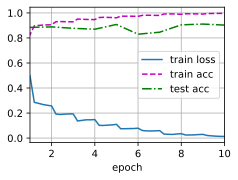

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)